## Part I: Data Cleaning and Feature Engineering
## Step 1. Import Packages


In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import linear_model
import matplotlib.pyplot as plt
from datetime import datetime
import xgboost as xgb
import operator


## Step 2. Import data

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv') 
store = pd.read_csv('store.csv')
submission = pd.read_csv('sample_submission.csv')

C:\Users\heman\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Step 3. Drop duplicates - Train Table and Store Table

In [4]:
store = store.drop_duplicates()
train = train.drop_duplicates()

## Step 4. Outlier Detection

In [5]:
IQR = train.Sales.quantile(0.75) - train.Sales.quantile(0.25)
low = train.Sales.quantile(0.25) - 3*IQR
high = train.Sales.quantile(0.75) + 3*IQR
train.Sales[(train.Sales <= high) & (train.Sales >= low)].count()

# Remove the 0.4% extreme outliers from the Train Data Table
train = train[(train.Sales <= high) & (train.Sales >= low)]


## Step 5. Missing Values

In [6]:
train.isnull().sum()
test.isnull().sum()
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [7]:
# a) Test Table: 
# The store should be open in the test,so we fillna with 1
# Fill the 11 NAs in the 'Open' Column of the test set with 1s, which indicates 'openning' (We assume they are opening)

test.fillna(1, inplace=True)


In [8]:
# b) Store Table
# Replace NAs in the 'CompetitionOpenSinceYear' with Median (2010)
store['CompetitionOpenSinceYear'] = store['CompetitionOpenSinceYear'].fillna(store['CompetitionOpenSinceYear'].median())
# Replace NAs in the 'CompetitionOpenSinceMonth' with Median (8-Aug)
store['CompetitionOpenSinceMonth'] = store['CompetitionOpenSinceMonth'].fillna(store['CompetitionOpenSinceMonth'].median())
# Replace NAs in the 'CompetitionDistance' with Median (2325.0)
store['CompetitionDistance'] = store['CompetitionDistance'].fillna(store['CompetitionDistance'].median())

In [ ]:
store.Promo2.count()
store.Promo2[store.Promo2 == 0].count()
store.Promo2[store.Promo2 == 1].count()
# Out of the 1115 unique stores, 571 are partcipating, 544 are not participating.

In [9]:
# Fill the 544 NAs in the 'Promo2SinceWeek'/'Promo2SinceYear'/'PromoInterval' Columns
# of the test set with 0s, which indicates 'no promotion going on'
store.fillna(0, inplace=True)


## Step 6. Feature Engineering: Get store Sales Mean and Sales Standard Deviation:

In [11]:
Store_mean = train.groupby('Store')['Sales'].mean()
Store_std = train.groupby('Store')['Sales'].std()
Store_mean_df = pd.DataFrame(Store_mean).reset_index()
Store_std_df = pd.DataFrame(Store_std).reset_index()

In [12]:
store = pd.merge(store,Store_mean_df, on='Store', how='left').rename(columns={"Sales": "Store_SalesMean"})
store = pd.merge(store,Store_std_df, on='Store', how='left').rename(columns={"Sales": "Store_SalesStd"})


## Step 7. Feature Enginnering: Dates

In [13]:
# a) Convert to the right date formats:
train['Date'] = pd.to_datetime(train.Date)
test['Date'] = pd.to_datetime(test.Date)


# b)  Year
train['Year'] = train['Date'].dt.year
test['Year'] = test['Date'].dt.year

# c)  Month
train['Month'] = train['Date'].dt.month
test['Month'] = test['Date'].dt.month

# d)  Weeknum
train['Weeknum'] = train['Date'].dt.week
test['Weeknum'] = test['Date'].dt.week

# e)  Quarter
train['Quarter'] = train['Date'].dt.quarter
test['Quarter'] = test['Date'].dt.quarter

# f)  YearMonth
train['YearMonth'] = train['Date'].dt.to_period('M')
test['YearMonth'] = test['Date'].dt.to_period('M')

# g)  Weekday
train['DayOfWeek'] = train['Date'].dt.weekday + 1
test['DayOfWeek'] = test['Date'].dt.weekday + 1

# h)  Weekend Flag
train['WeekendFlag'] = 0
train['WeekendFlag'][train['DayOfWeek'] >= 6] = 1
test['WeekendFlag'] = 0
test['WeekendFlag'][test['DayOfWeek'] >= 6] = 1

C:\Users\heman\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\heman\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Step 8. Feature Engineering: Promotion Interval 

In [14]:
store.PromoInterval.replace('0', 0,inplace=True)
store.PromoInterval.replace('Jan,Apr,Jul,Oct', 1,inplace=True)
store.PromoInterval.replace('Feb,May,Aug,Nov', 2,inplace=True)
store.PromoInterval.replace('Mar,Jun,Sept,Dec', 3,inplace=True)

## Step 9. Feature Engineering: Get the Monthly Total Sales

In [16]:
Month_sales_sum = train.groupby('Month')['Sales'].sum()
Month_sales_sum_df = pd.DataFrame(Month_sales_sum).reset_index().rename(columns={"Sales": "Monthly_SalesSum"})

In [17]:
train = pd.merge(train,Month_sales_sum_df, on='Month', how='left')
test = pd.merge(test,Month_sales_sum_df, on='Month', how='left')

## Step 10. Feature Engineering: Get Monthly Total Number of Customers:

In [18]:
Month_customers_sum = train.groupby('Month')['Customers'].sum()
Month_customers_sum_df = pd.DataFrame(Month_customers_sum).reset_index().rename(columns={"Customers": "Monthly_CustomersSum"})

In [19]:
train = pd.merge(train,Month_customers_sum_df, on='Month', how='left')
test = pd.merge(test,Month_customers_sum_df, on='Month', how='left')

## Step 11. We only use the data of Sales > 0 and Open is 1

In [20]:
# Remove sales less than or equal to zero 
train_open = train[(train["Open"] != 0) & (train["Sales"] > 0)]
test_open = test[test["Open"] != 0]

## Step 12. Join the tables (Train + Store & Test + Store)

In [21]:
train_combined = pd.merge(train_open[['Store','DayOfWeek','Date','Sales','Promo','StateHoliday','SchoolHoliday','Year','Month','Weeknum','Quarter','YearMonth','WeekendFlag','Monthly_SalesSum','Monthly_CustomersSum']], store, on='Store', how='left')
test_combined = pd.merge(test_open[['Id','Store','DayOfWeek','Date','Promo','StateHoliday','SchoolHoliday','Year','Month','Weeknum','Quarter','YearMonth','WeekendFlag','Monthly_SalesSum','Monthly_CustomersSum']], store, on='Store', how='left')

## Step 13. Feature Engineering: Promo2 related features

In [23]:
# a) In the train set
train_combined['Promo2_ongoing'] = ((train_combined.Promo2 == 1) & (train_combined.Year > train_combined.Promo2SinceYear)).astype(int) + \
                                    ((train_combined.Promo2 == 1) & (train_combined.Year == train_combined.Promo2SinceYear) & (train_combined.Weeknum >= train_combined.Promo2SinceWeek)).astype(int)
                                    
train_combined['Promo2_ongoing_now'] = ((train_combined['Promo2_ongoing'] == 1) & (train_combined.Month % 3 == train_combined.PromoInterval % 3)).astype(int) 

train_combined.drop(['Promo2','Promo2SinceWeek','Promo2SinceYear','PromoInterval','Promo2_ongoing'], axis = 1, inplace=True)

In [22]:
# b) In the test set:
test_combined['Promo2_ongoing'] = ((test_combined.Promo2 == 1) & (test_combined.Year > test_combined.Promo2SinceYear)).astype(int) + \
                                    ((test_combined.Promo2 == 1) & (test_combined.Year == test_combined.Promo2SinceYear) & (test_combined.Weeknum >= test_combined.Promo2SinceWeek)).astype(int)
                                    
test_combined['Promo2_ongoing_now'] = ((test_combined['Promo2_ongoing'] == 1) & (test_combined.Month % 3 == test_combined.PromoInterval % 3)).astype(int) 

test_combined.drop(['Promo2','Promo2SinceWeek','Promo2SinceYear','PromoInterval','Promo2_ongoing'], axis = 1, inplace=True)


## Step 14. Feature Engineering: Competition related features

In [24]:
# a) In the train set
train_combined['CompetitionOpen'] = ((train_combined.Year > train_combined.CompetitionOpenSinceYear)).astype(int) + \
                                    ((train_combined.Year == train_combined.CompetitionOpenSinceYear) & (train_combined.Month >= train_combined.CompetitionOpenSinceMonth)).astype(int)

train_combined.CompetitionOpenSinceYear = train_combined.CompetitionOpenSinceYear.astype(int)
train_combined.CompetitionOpenSinceMonth = train_combined.CompetitionOpenSinceMonth.astype(int)

train_combined['NumOfCompetitionOpenMonths'] = train_combined['CompetitionOpen'] * ((train_combined.Year * 12 + train_combined.Month) - (train_combined.CompetitionOpenSinceYear * 12 + train_combined.CompetitionOpenSinceMonth))

train_combined.drop(['CompetitionOpenSinceYear','CompetitionOpenSinceMonth'], axis = 1, inplace=True)

train_combined['CompetitionDistance'] = train_combined['CompetitionDistance'] * train_combined['CompetitionOpen']


In [25]:
# b) In the test set
test_combined['CompetitionOpen'] = ((test_combined.Year > test_combined.CompetitionOpenSinceYear)).astype(int) + \
                                    ((test_combined.Year == test_combined.CompetitionOpenSinceYear) & (test_combined.Month >= test_combined.CompetitionOpenSinceMonth)).astype(int)

test_combined.CompetitionOpenSinceYear = test_combined.CompetitionOpenSinceYear.astype(int)
test_combined.CompetitionOpenSinceMonth = test_combined.CompetitionOpenSinceMonth.astype(int)

test_combined['NumOfCompetitionOpenMonths'] = test_combined['CompetitionOpen'] * ((test_combined.Year * 12 + test_combined.Month) - (test_combined.CompetitionOpenSinceYear * 12 + test_combined.CompetitionOpenSinceMonth))

test_combined.drop(['CompetitionOpenSinceYear','CompetitionOpenSinceMonth'], axis = 1, inplace=True)

test_combined['CompetitionDistance'] = test_combined['CompetitionDistance'] * test_combined['CompetitionOpen']


## Step 15. Feature Engineering: Convert the 'StateHoliday' into 0 & 1

In [26]:
train_combined.StateHoliday[(train_combined.StateHoliday == 'a') | (train_combined.StateHoliday == 'b') | (train_combined.StateHoliday == 'c')] = 1
test_combined.StateHoliday[(test_combined.StateHoliday == 'a') | (test_combined.StateHoliday == 'b') | (test_combined.StateHoliday == 'c')] = 1
train_combined.StateHoliday = train_combined.StateHoliday.astype(int)
test_combined.StateHoliday = test_combined.StateHoliday.astype(int)

C:\Users\heman\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\heman\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Step 16. Order the columns

In [27]:
# a) In the train set:
train_combined = train_combined[['Sales', # Target Variable
                                 'Store', # Store id
                                 'StoreType', # Store Type: Categorical
                                 'Date','Year','Month','YearMonth','Quarter','Weeknum','DayOfWeek', # Time Related
                                 'WeekendFlag','StateHoliday','SchoolHoliday', # Weekend & Holiday
                                 'Promo','Promo2_ongoing_now', # Promotions(Binary Flag) 
                                 'CompetitionOpen','CompetitionDistance','NumOfCompetitionOpenMonths', # Competitions
                                 'Monthly_SalesSum','Monthly_CustomersSum', # Average Sales and Average Customer Number in the same month
                                 'Store_SalesMean','Store_SalesStd', # Store Average Sales and Variance
                                 'Assortment']] # Assortment
# b) In the test set:
test_combined = test_combined[['Id', # Prediction Identifier
                               'Store', # Store id
                               'StoreType', # Store Type: Categorical
                               'Date','Year','Month','YearMonth','Quarter','Weeknum','DayOfWeek', # Time Related
                               'WeekendFlag','StateHoliday','SchoolHoliday', # Weekend & Holiday
                               'Promo','Promo2_ongoing_now', # Promotions(Binary Flag) 
                               'CompetitionOpen','CompetitionDistance','NumOfCompetitionOpenMonths', # Competitions
                               'Monthly_SalesSum','Monthly_CustomersSum', # Average Sales and Average Customer Number in the same month
                               'Store_SalesMean','Store_SalesStd', # Store Average Sales and Variance
                               'Assortment']] # Assortment


In [28]:
# In order to capture the average 
train_combined['Year_Quarter'] = train_combined['Year'] * 4 + train_combined['Quarter']
test_combined['Year_Quarter'] = test_combined['Year'] * 4 + test_combined['Quarter']

# We actually get the total sales per store in each quarter
sales_by_quarter = train_combined.groupby(['Store','Year_Quarter'])['Sales'].sum().reset_index()
sales_by_quarter['Next_Quarter'] = sales_by_quarter['Year_Quarter'] + 1
sales_by_quarter = sales_by_quarter.rename(columns={'Year_Quarter': 'This_Quarter','Sales': 'Last_quarter_sales'})

train_combined = pd.merge(train_combined,sales_by_quarter,left_on = ['Store','Year_Quarter'],right_on =['Store','Next_Quarter'], how = 'left')
test_combined = pd.merge(test_combined,sales_by_quarter,left_on = ['Store','Year_Quarter'],right_on =['Store','Next_Quarter'], how = 'left')

# Drop Necessary columns 
train_combined = train_combined.drop(['This_Quarter','Next_Quarter','Year_Quarter'],axis = 1)
test_combined = test_combined.drop(['This_Quarter','Next_Quarter','Year_Quarter'],axis = 1)


# Check the number of NA in each columns
train_combined.isnull().sum()
test_combined.isnull().sum()

# According to the result, there are 96807 rows with NA in the 'Last_quarter_sales', when the stores are newly opened or in 2013 Q1
train_combined = train_combined.dropna()


## Step 17. Split the data into two parts -- features (X) and target variable (y) or Id

In [29]:
# Meanwhile, drop these variables: 'Store','Date','Year','YearMonth','Weeknum', 'WeekendFlag'
train_combined_X = train_combined.iloc[:,1:].drop(['Store','Date','Year','YearMonth','Weeknum','WeekendFlag'],axis = 1)
test_combined_X = test_combined.iloc[:,1:].drop(['Store','Date','Year','YearMonth','Weeknum','WeekendFlag'],axis = 1)
train_combined_y = train_combined.iloc[:,0]
test_combined_id = test_combined.iloc[:,0]

train_combined.Date.min()
train_combined.Date.max()
test_combined.Date.min()
test_combined.Date.max()


Timestamp('2015-09-17 00:00:00')

In [37]:
train_combined_X.columns

Index(['StateHoliday', 'SchoolHoliday', 'Promo', 'Promo2_ongoing_now',
       'CompetitionOpen', 'CompetitionDistance', 'NumOfCompetitionOpenMonths',
       'Monthly_SalesSum', 'Monthly_CustomersSum', 'Store_SalesMean',
       'Store_SalesStd', 'Last_quarter_sales', 'TestFlag', 'StoreType_a',
       'StoreType_b', 'StoreType_c', 'StoreType_d', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8',
       'Month_9', 'Month_10', 'Month_11', 'Month_12', 'Quarter_1', 'Quarter_2',
       'Quarter_3', 'Quarter_4', 'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Assortment_a', 'Assortment_b', 'Assortment_c'],
      dtype='object')

## Step 18. Convert Categorical Variables in to Dummies

In [31]:
# Convert these variables: 'StoreType','Month','Quarter','DayOfWeek','Assortment'
# In order to make sure that the conversion is done in parrellel for train set and test set, we combine the train and test set and then do the dummy conversion
train_combined_X['TestFlag'] = 0
test_combined_X['TestFlag'] = 1
combined_X = train_combined_X.append(test_combined_X)
combined_X = pd.get_dummies(data = combined_X, columns = ['StoreType','Month','Quarter','DayOfWeek','Assortment'])


## Step 19. Split the combined into train and test features

In [32]:
train_combined_X = combined_X[combined_X.TestFlag == 0]
test_combined_X = combined_X[combined_X.TestFlag == 1]

# Part II: Fit the Model

## Model 1: Linear Regression

In [33]:
regr = linear_model.LinearRegression()
regr.fit(train_combined_X,train_combined_y)
test_combined_df = pd.DataFrame(test_combined_id)
test_combined_df['Pred'] = regr.predict(test_combined_X)

# Edit the submission format
submission_regr = pd.merge(submission,test_combined_df, on = 'Id',how = 'left')
submission_regr = submission_regr.fillna(0).drop(['Sales'],axis = 1).rename(columns={"Pred": "Sales"})
submission_regr.to_csv("submission_regr_3.csv", index=False)


### Submission Performance
### 1) Private Score: 0.19544
### 2) Public Score: 0.18629

## Model 2: Linear Regression: Drop 'CompetitionDistance' and 'NumOfCompetitionOpenMonths'

In [40]:
train_combined_X_2 = train_combined_X.drop(['CompetitionDistance','NumOfCompetitionOpenMonths'], axis = 1)
test_combined_X_2 = test_combined_X.drop(['CompetitionDistance','NumOfCompetitionOpenMonths'], axis = 1)

regr = linear_model.LinearRegression()
regr.fit(train_combined_X_2,train_combined_y)
test_combined_df = pd.DataFrame(test_combined_id)
test_combined_df['Pred'] = regr.predict(test_combined_X_2)

# Edit the submission format
submission_regr = pd.merge(submission,test_combined_df, on = 'Id',how = 'left')
submission_regr = submission_regr.fillna(0).drop(['Sales'],axis = 1).rename(columns={"Pred": "Sales"})
submission_regr.to_csv("submission_regr_4.csv", index=False)

# Notice: Accoring to the submission result, dropping 'CompetitionDistance' and 'NumOfCompetitionOpenMonths' will give us slightly better performance

### Submission Performance
### 1) Private Score: 0.19511
### 2) Public Score: 0.18613


## Model 3: Random Forest

In [41]:
# define eval metrics
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

# Fit random forest model
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(n_estimators = 15)
clf.fit(train_combined_X_2, train_combined_y)

test_combined_df = pd.DataFrame(test_combined_id)
test_combined_df['Pred'] = clf.predict(test_combined_X_2)

# Edit the submission format
submission_rf = pd.merge(submission,test_combined_df, on = 'Id',how = 'left')
submission_rf = submission_rf.fillna(0).drop(['Sales'],axis = 1).rename(columns={"Pred": "Sales"})
submission_rf.to_csv("submission_rf.csv", index=False)



### Submission Performance
### 1) Private Score: 0.13759
### 2) Public Score: 0.12739


## Model 4: Random Forest (with Feature Selection)

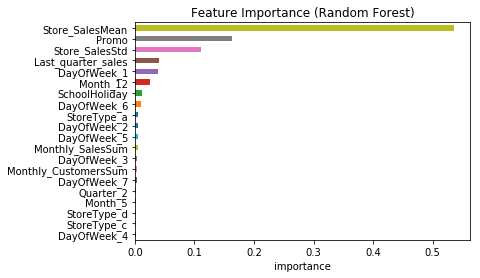

In [42]:
# plot feature importance for random forest model, show top 20 features
feat_importances = pd.Series(clf.feature_importances_, index=train_combined_X_2.columns)
feat_importances.nlargest(20).sort_values(ascending = True).plot(kind='barh')
plt.xlabel('importance')
plt.title('Feature Importance (Random Forest)')

# According to the feature importance rank, the most important features are:
# 'Store_SalesMean', 'Promo', 'Store_SalesStd', 'Last_quarter_sales', 'DayOfWeek_1', 'Month_12',
# 'SchoolHoliday', 'DayOfWeek_6' 

train_combined_X_3 = train_combined_X_2[['Store_SalesMean', 'Promo', 'Store_SalesStd', 'Last_quarter_sales', 'DayOfWeek_1', 'Month_12','SchoolHoliday', 'DayOfWeek_6']]
test_combined_X_3 = test_combined_X_2[['Store_SalesMean', 'Promo', 'Store_SalesStd', 'Last_quarter_sales', 'DayOfWeek_1', 'Month_12','SchoolHoliday', 'DayOfWeek_6']]


clf = RandomForestRegressor(n_estimators = 15)
clf.fit(train_combined_X_3, train_combined_y)

test_combined_df = pd.DataFrame(test_combined_id)
test_combined_df['Pred'] = clf.predict(test_combined_X_3)

# Edit the submission format
submission_rf = pd.merge(submission,test_combined_df, on = 'Id',how = 'left')
submission_rf = submission_rf.fillna(0).drop(['Sales'],axis = 1).rename(columns={"Pred": "Sales"})
submission_rf.to_csv("submission_rf2.csv", index=False)


### Submission Performance
### 1) Private Score: 0.17009
### 2) Public Score: 0.15546

## Model 5: XGBoost (Without Feature Selection)

In [44]:
# Feature Importance Evaluation:
# Based on https://www.kaggle.com/mmueller/liberty-mutual-group-property-inspection-prediction/xgb-feature-importance-python/code

def ceate_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1

    outfile.close()


features = list(train_combined_X_2.columns)

ceate_feature_map(features)

# Train the model
xgb_params = {"objective": "reg:linear", "eta": 0.01, "max_depth": 8, "seed": 42, "silent": 1}
num_rounds = 1000

dtrain = xgb.DMatrix(train_combined_X_2, label=train_combined_y)
gbdt = xgb.train(xgb_params, dtrain, num_rounds)


# Make predictions on the test set:

test_combined_df = pd.DataFrame(test_combined_id)
dtest = xgb.DMatrix(test_combined_X_2)
test_combined_df['Pred'] = gbdt.predict(dtest)


# Edit the submission format
submission_xgb = pd.merge(submission,test_combined_df, on = 'Id',how = 'left')
submission_xgb = submission_xgb.fillna(0).drop(['Sales'],axis = 1).rename(columns={"Pred": "Sales"})
submission_xgb.to_csv("submission_xgb3.csv", index=False)



## Hyper parameter Tuning using GridSearch

In [ ]:

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [6],
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [5], #number of trees, change it to 1000 for better results
              'missing':[-999],
              'seed': [1337]}


clf = GridSearchCV(xgb_model, parameters, n_jobs=5, 
                   cv=StratifiedKFold(train['QuoteConversion_Flag'], n_folds=5, shuffle=True), 
                   scoring='roc_auc',
                   verbose=2, refit=True)

clf.fit(train[features], train["QuoteConversion_Flag"])

best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])

### Submission Performance
### 1) Private Score: 0.14203
### 2) Public Score: 0.13369


## Model 6: XGBoost (With Feature Selection)

In [ ]:
importance = gbdt.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

plt.figure()
df.plot()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('feature_importance_xgb.png')

# According to the feature importance result, the important features are (Top 25)
# 'Store_SalesMean', 'Store_SalesStd','Last_quarter_sales','Monthly_SalesSum', 'SchoolHoliday', 'Promo',
# 'DayOfWeek_6', 'Month_12', 'DayOfWeek_5', 'DayOfWeek_1','DayOfWeek_2','StoreType_a', 'DayOfWeek_3', 
# 'StateHoliday','DayOfWeek_7','DayOfWeek_4', 'Assortment_a','Monthly_CustomersSum',
# 'StoreType_d','StoreType_c','Quarter_1','Promo2_ongoing_now','Month_5', 'CompetitionOpen','Quarter_3'

# Take the Top 25 most important features
train_combined_X_xgb = train_combined_X_2[['Store_SalesMean', 'Store_SalesStd','Last_quarter_sales','Monthly_SalesSum', 'SchoolHoliday', 'Promo',
                                           'DayOfWeek_6', 'Month_12', 'DayOfWeek_5', 'DayOfWeek_1','DayOfWeek_2','StoreType_a', 'DayOfWeek_3', 
                                           'StateHoliday','DayOfWeek_7','DayOfWeek_4', 'Assortment_a','Monthly_CustomersSum',
                                           'StoreType_d','StoreType_c','Quarter_1','Promo2_ongoing_now','Month_5', 'CompetitionOpen','Quarter_3']]

test_combined_X_xgb = test_combined_X_2[['Store_SalesMean', 'Store_SalesStd','Last_quarter_sales','Monthly_SalesSum', 'SchoolHoliday', 'Promo',
                                           'DayOfWeek_6', 'Month_12', 'DayOfWeek_5', 'DayOfWeek_1','DayOfWeek_2','StoreType_a', 'DayOfWeek_3', 
                                           'StateHoliday','DayOfWeek_7','DayOfWeek_4', 'Assortment_a','Monthly_CustomersSum',
                                           'StoreType_d','StoreType_c','Quarter_1','Promo2_ongoing_now','Month_5', 'CompetitionOpen','Quarter_3']]


# Make predictions on the test set:
dtrain2 = xgb.DMatrix(train_combined_X_xgb, label=train_combined_y)
gbdt2 = xgb.train(xgb_params, dtrain2, num_rounds)

test_combined_df = pd.DataFrame(test_combined_id)
dtest2 = xgb.DMatrix(test_combined_X_xgb)
test_combined_df['Pred'] = gbdt2.predict(dtest2)


# Edit the submission format
submission_xgb = pd.merge(submission,test_combined_df, on = 'Id',how = 'left')
submission_xgb = submission_xgb.fillna(0).drop(['Sales'],axis = 1).rename(columns={"Pred": "Sales"})
submission_xgb.to_csv("submission_xgb4.csv", index=False)

### Submission Performance
### 1) Private Score: 0.14230
### 2) Public Score: 0.13263


## Model 7: XGBoost (With Feature Selection)

In [ ]:
# Take the Top 10 most important features
train_combined_X_xgb2 = train_combined_X_2[['Store_SalesMean', 'Store_SalesStd','Last_quarter_sales','Monthly_SalesSum', 'SchoolHoliday', 'Promo',
                                           'DayOfWeek_6', 'Month_12', 'DayOfWeek_5', 'DayOfWeek_1']]

test_combined_X_xgb2 = test_combined_X_2[['Store_SalesMean', 'Store_SalesStd','Last_quarter_sales','Monthly_SalesSum', 'SchoolHoliday', 'Promo',
                                           'DayOfWeek_6', 'Month_12', 'DayOfWeek_5', 'DayOfWeek_1']]


# Make predictions on the test set:
dtrain3 = xgb.DMatrix(train_combined_X_xgb2, label=train_combined_y)
gbdt3 = xgb.train(xgb_params, dtrain3, num_rounds)

test_combined_df = pd.DataFrame(test_combined_id)
dtest3 = xgb.DMatrix(test_combined_X_xgb2)
test_combined_df['Pred'] = gbdt3.predict(dtest3)


# Edit the submission format
submission_xgb = pd.merge(submission,test_combined_df, on = 'Id',how = 'left')
submission_xgb = submission_xgb.fillna(0).drop(['Sales'],axis = 1).rename(columns={"Pred": "Sales"})
submission_xgb.to_csv("submission_xgb5.csv", index=False)

### Submission Performance
### 1) Private Score: 0.14230
### 2) Public Score: 0.13263